# Mini-project XAI -- RISE


* BOUTRID Mourad
* KASSIMI Achraf
* 11/12/2025

# **Context & Motivation**

RISE seeks to solve the "black box" problem of Convolutional Neural Networks (CNNs) by identifying exactly which parts of an image contribute most to a specific prediction (for example, showing which pixels caused the model to recognize a "cat"). Because it generates an explanation for a single specific input instance (an image) rather than describing the general logic of the entire network, it is classified as a local explanation method.

# **RISE intuitively:**

we have this machine—this model—and it’s a black box(we don't know what's happening inside). we feed it a photo, and it shouts "Cat!" But we have no idea why it said cat. We can’t open the box to look at the gears inside because the math is too messy.

**The swiss cheese experiment**

Imagine we take a piece of Swiss cheese—lots of random holes in it—and we slap it over the photo. Now, parts of the photo are hidden, and parts are visible. we show this "masked" photo to the machine and ask:
"What do you see now?"



*   If the cheese covers the cat’s face and the machine says, "I don't know what that is," we know that the face was important.
*   If the cheese covers the background grass but leaves the face visible, and the machine still shouts "Cat!", we know the grass didn't matter.



The **RISE method** is just doing this thousands of times. we throw thousands of random, cloudy masks over the image, record the score for every single one, and see which parts of the image survive the test.

**the output:**

Every time the machine successfully recognized the cat, we take the mask we used and stack it on a pile. After 5,000 tries, we look at the pile. The spots where the masks were transparent (the holes) will stack up and become very bright. The spots that didn't matter stay dark.

So, we get a glowing map that says: "Here! This specific spot (the ears and the nose) is what makes the machine tick.

because we mess with the image, measure the drop in confidence, and build a map. is is considered a **Perturbation based** method

# **Mathematical Formulation**

We now formalize the intuition behind the masking-based saliency procedure. The method is governed by a central equation that describes how the saliency map is formed through a weighted aggregation of random masks.

---

## **Key Equation**

The saliency map \( S \) is computed as a normalized, weighted sum of all sampled binary masks:

$$
S = \frac{1}{p} \mathbb{E}_{M} \left[ f(I \odot M) \, M \right]
$$

---

## **Definition of Symbols**

- **\( S \)** — The resulting saliency map (the pixel-wise importance heatmap).  
- **\( N \)** — Total number of randomly generated masks.  
- **\( M_i \)** — The \( i \)-th binary mask with values in \(\{0, 1\}\).  
- **\( I \)** — The original input image.  
- **$ (\odot)$**  — Element-wise product; \$ (\odot)$ applies mask \( M_i \) to image \( I \).  

- **$( f(\cdot) )$** — The black-box model that outputs a scalar score (e.g., a class probability).  
- **\( p \)** — Probability that a pixel remains visible in each random mask (normalization factor).  

---

## **Interpretation**


### **Score-Weighted Masks**

Each mask \( M_i \) is multiplied by the model's response to the masked image:

$$
f(I \odot M_i)
$$

- High score → the mask contributes strongly.  
- Low score → the mask contributes weakly.  

---


## **Computational Challenge**

While the equation above defines the exact theoretical saliency, computing the expected value $\mathbb{E}_{M}$ directly is **computationally infeasible**.

### **Why the exact formula is intractable:**

* **Combinatorial Explosion:** The expectation implies summing over the entire probability space of all possible masks. For an image with $d$ pixels, there are $2^d$ unique binary masks.
* **Impossible Scale:** Even for a small $50 \times 50$ pixel image, the number of potential masks is $2^{2500}$. Running the model $f(\cdot)$ for every combination exceeds the processing power of any computer.

Consequently, we cannot calculate $S$ exactly and must rely on estimation methods.

---

## **Monte Carlo Interpretation**

This method is a Monte Carlo approximation of pixel importance:

- Exact pixel-level importance is intractable to compute.  
- Sampling many random masks provides an unbiased estimate.  
- As \( N \) increases, the result converges to the expected contribution of each pixel.

$$
S \approx \frac{1}{N\,p} \sum_{i=1}^{N} f(I \odot M_i)\, M_i
$$

# IMPLEMENTATION

### **Setup and Model Training**

This cell initializes the environment by importing necessary libraries (PyTorch, NumPy, Matplotlib) and setting up the configuration (Device, Batch Size). It loads the MNIST dataset for training and testing. Then, it defines a simple Convolutional Neural Network (`SimpleCNN`), initializes the model, loss function, and optimizer, and trains the model for a few epochs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

#Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 3 # Kept low for demonstration speed

#Prepare Data (MNIST)
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False) # Batch size 1 for easy explanation later

#Define the "Black Box" Model (we use Simple CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # Return probabilities

model = SimpleCNN().to(DEVICE)

# Train the Model (Quick Training Loop)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Model...")
model.train()
for epoch in range(EPOCHS):
    for data, target in trainloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
print("Model Trained!")

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


Training Model...
Model Trained!


### **Model Evaluation**

This cell evaluates the trained model on the test dataset. It defines functions to calculate accuracy and visualize the confusion matrix. It also displays a sample of predictions with their confidence scores to qualitatively assess model performance.

Evaluating model on Test Set...

Model Accuracy: 98.07%


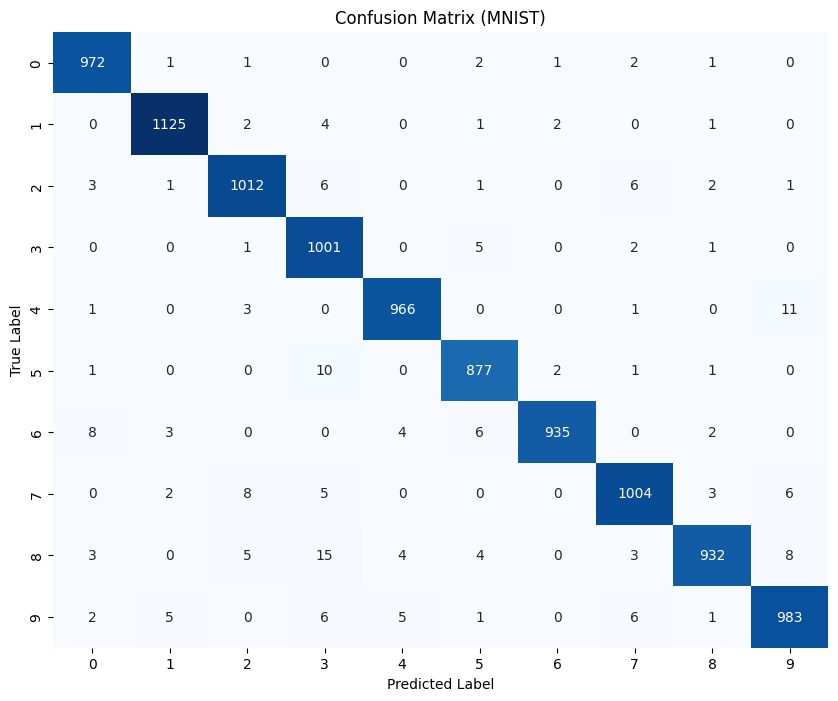

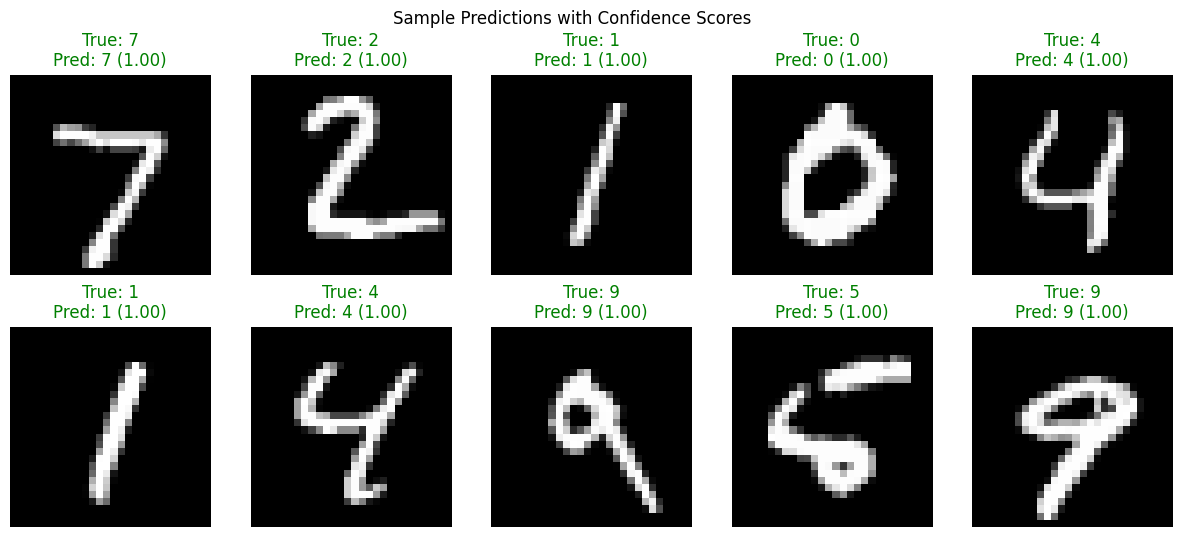

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    # 1. Collect all predictions
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # Get the index of the max log-probability
            preds = output.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_targets), np.array(all_preds)

# Run Evaluation on Test Set
print("Evaluating model on Test Set...")
y_true, y_pred = evaluate_model(model, testloader)

# Calculate Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {acc * 100:.2f}%")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MNIST)')
plt.show()

# Visualize Specific Predictions
def visualize_predictions(loader, model, num_images=10):
    model.eval()
    images, labels = next(iter(loader))

    data_iter = iter(loader)

    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        img, label = next(data_iter)
        img = img.to(DEVICE)

        # Get prediction and confidence
        with torch.no_grad():
            output = model(img)
            probs = output.squeeze() # Remove batch dim
            pred_score, pred_label = torch.max(probs, 0)

        # Plot
        ax = plt.subplot(2, 5, i + 1)
        img_np = img.cpu().squeeze().numpy()
        plt.imshow(img_np, cmap='gray')

        # Color title: Green if correct, Red if wrong
        color = 'green' if pred_label.item() == label.item() else 'red'
        plt.title(f"True: {label.item()}\nPred: {pred_label.item()} ({pred_score.item():.2f})", color=color)
        plt.axis('off')

    plt.suptitle("Sample Predictions with Confidence Scores")
    plt.show()

# Visualize 10 random samples
visualize_predictions(testloader, model, num_images=10)

Visualizing False Predictions...


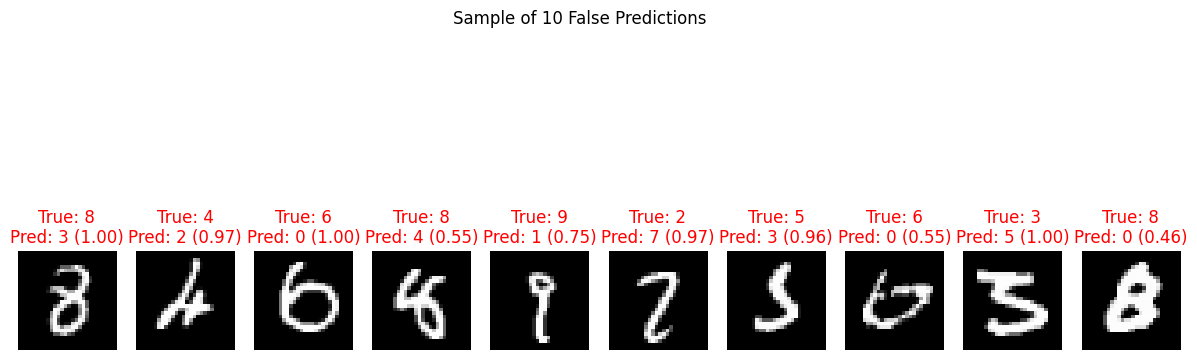

In [3]:
def visualize_false_predictions(loader, model, num_images=5):
    model.eval()
    false_predictions = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            probs = output.squeeze()
            pred_score, pred_label = torch.max(probs, 0)

            if pred_label.item() != target.item():
                false_predictions.append((data.cpu().squeeze().numpy(), target.item(), pred_label.item(), pred_score.item()))
            if len(false_predictions) >= num_images:
                break

    if not false_predictions:
        print("No false predictions found in the sampled batch.")
        return

    plt.figure(figsize=(15, 6))
    for i, (img_np, true_label, pred_label, pred_score) in enumerate(false_predictions):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_score:.2f})", color='red')
        plt.axis('off')

    plt.suptitle(f"Sample of {len(false_predictions)} False Predictions")
    plt.show()

print("Visualizing False Predictions...")
visualize_false_predictions(testloader, model, num_images=10)

### **RISE Algorithm Implementation**

This cell defines the `RISE` class. It implements the core logic of the algorithm: generating random masks, perturbing the input image, querying the model, and aggregating the weighted masks to compute the saliency map.

In [4]:
import torch.nn.functional as F
from tqdm import tqdm

class RISE(nn.Module):
    def __init__(self, model, input_size=(28, 28), gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1):
        """
        N: Number of masks
        s: Grid size (the resolution of the random holes)
        p1: Probability of a pixel being visible (1)
        """
        # Create a low-resolution binary grid (small random holes)
        # We add extra padding to allow for shifting/cropping if desired,
        # but here we keep it simple: generate exactly s x s
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        # Random binary grid (The "Swiss Cheese" slices)
        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        # Convert to Tensor
        masks = torch.from_numpy(grid).to(DEVICE)

        # Upsample to image size (The "Cloudy/Fuzzy" effect)
        # We need 4D tensor for interpolate: (N, Channels, H, W)
        masks = masks.unsqueeze(1)
        masks = F.interpolate(masks, size=self.input_size, mode='bilinear', align_corners=False)

        # Remove the channel dimension after upsampling: (N, 28, 28)
        return masks.squeeze(1)

    def forward(self, x, N=2000, s=8, p1=0.5):
        """
        x: Input image tensor (1, 1, 28, 28)
        """
        #Generate N random masks
        masks = self.generate_masks(N, s, p1)

        # Prepare accumulation container
        # The saliency map starts as all zeros
        saliency = torch.zeros(self.input_size).to(DEVICE)

        # Get the model's prediction for the unmasked image (to know which class to explain)
        with torch.no_grad():
            logits = self.model(x)
            target_class = logits.argmax(dim=1).item()

        # Process masks in batches (to save GPU memory)
        with torch.no_grad():
            for i in tqdm(range(0, N, self.gpu_batch), desc="RISE Sampling"):
                # Get a batch of masks
                batch_masks = masks[i:min(i + self.gpu_batch, N)]

                # Create masked inputs: Image * Mask
                # x is (1, 1, 28, 28), batch_masks is (Batch, 28, 28) -> Broadcasts correctly
                masked_input = x * batch_masks.unsqueeze(1)

                # Get scores from the model
                outputs = self.model(masked_input)

                # Extract the score for the Target Class only
                scores = outputs[:, target_class]

                # Weighted Accumulation: Saliency += Score * Mask
                # Reshape scores to (Batch, 1, 1) to multiply against (Batch, 28, 28)
                weighted_masks = scores.view(-1, 1, 1) * batch_masks
                saliency += weighted_masks.sum(dim=0)

        # Normalize
        # Expected value of mask is p1, so we divide by N * p1
        saliency = saliency / (N * p1)

        return saliency, target_class

# Initialize the explainer
rise_explainer = RISE(model)
print("RISE Explainer initialized.")

RISE Explainer initialized.


Visualizing a single mask application...


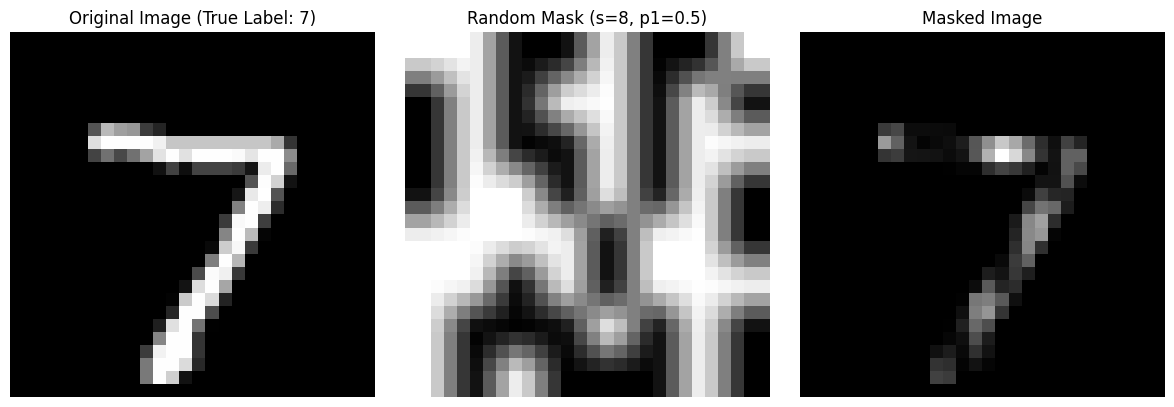

In [5]:
print("Visualizing a single mask application...")

# Get a sample image from the testloader
img, label = next(iter(testloader))
img = img.to(DEVICE)

# Generate a single mask using RISE's internal function (for demonstration)
# N=1 means we generate just one mask
s_val = 8 # Grid resolution
p1_val = 0.5 # Mask density
single_mask = rise_explainer.generate_masks(N=1, s=s_val, p1=p1_val)

# Apply the mask to the image
masked_img = img * single_mask.unsqueeze(1)

# Convert to numpy for plotting
img_np = img.cpu().squeeze().numpy()
single_mask_np = single_mask.cpu().squeeze().numpy()
masked_img_np = masked_img.cpu().squeeze().numpy()

plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Original Image (True Label: {label.item()})")
plt.axis('off')

# Generated Mask
plt.subplot(1, 3, 2)
plt.imshow(single_mask_np, cmap='gray')
plt.title(f"Random Mask (s={s_val}, p1={p1_val})")
plt.axis('off')

# Masked Image
plt.subplot(1, 3, 3)
plt.imshow(masked_img_np, cmap='gray')
plt.title("Masked Image")
plt.axis('off')

plt.tight_layout()
plt.show()

### **Visualization and Analysis Functions**

Running RISE on test images...


RISE Sampling: 100%|██████████| 30/30 [00:00<00:00, 2234.26it/s]


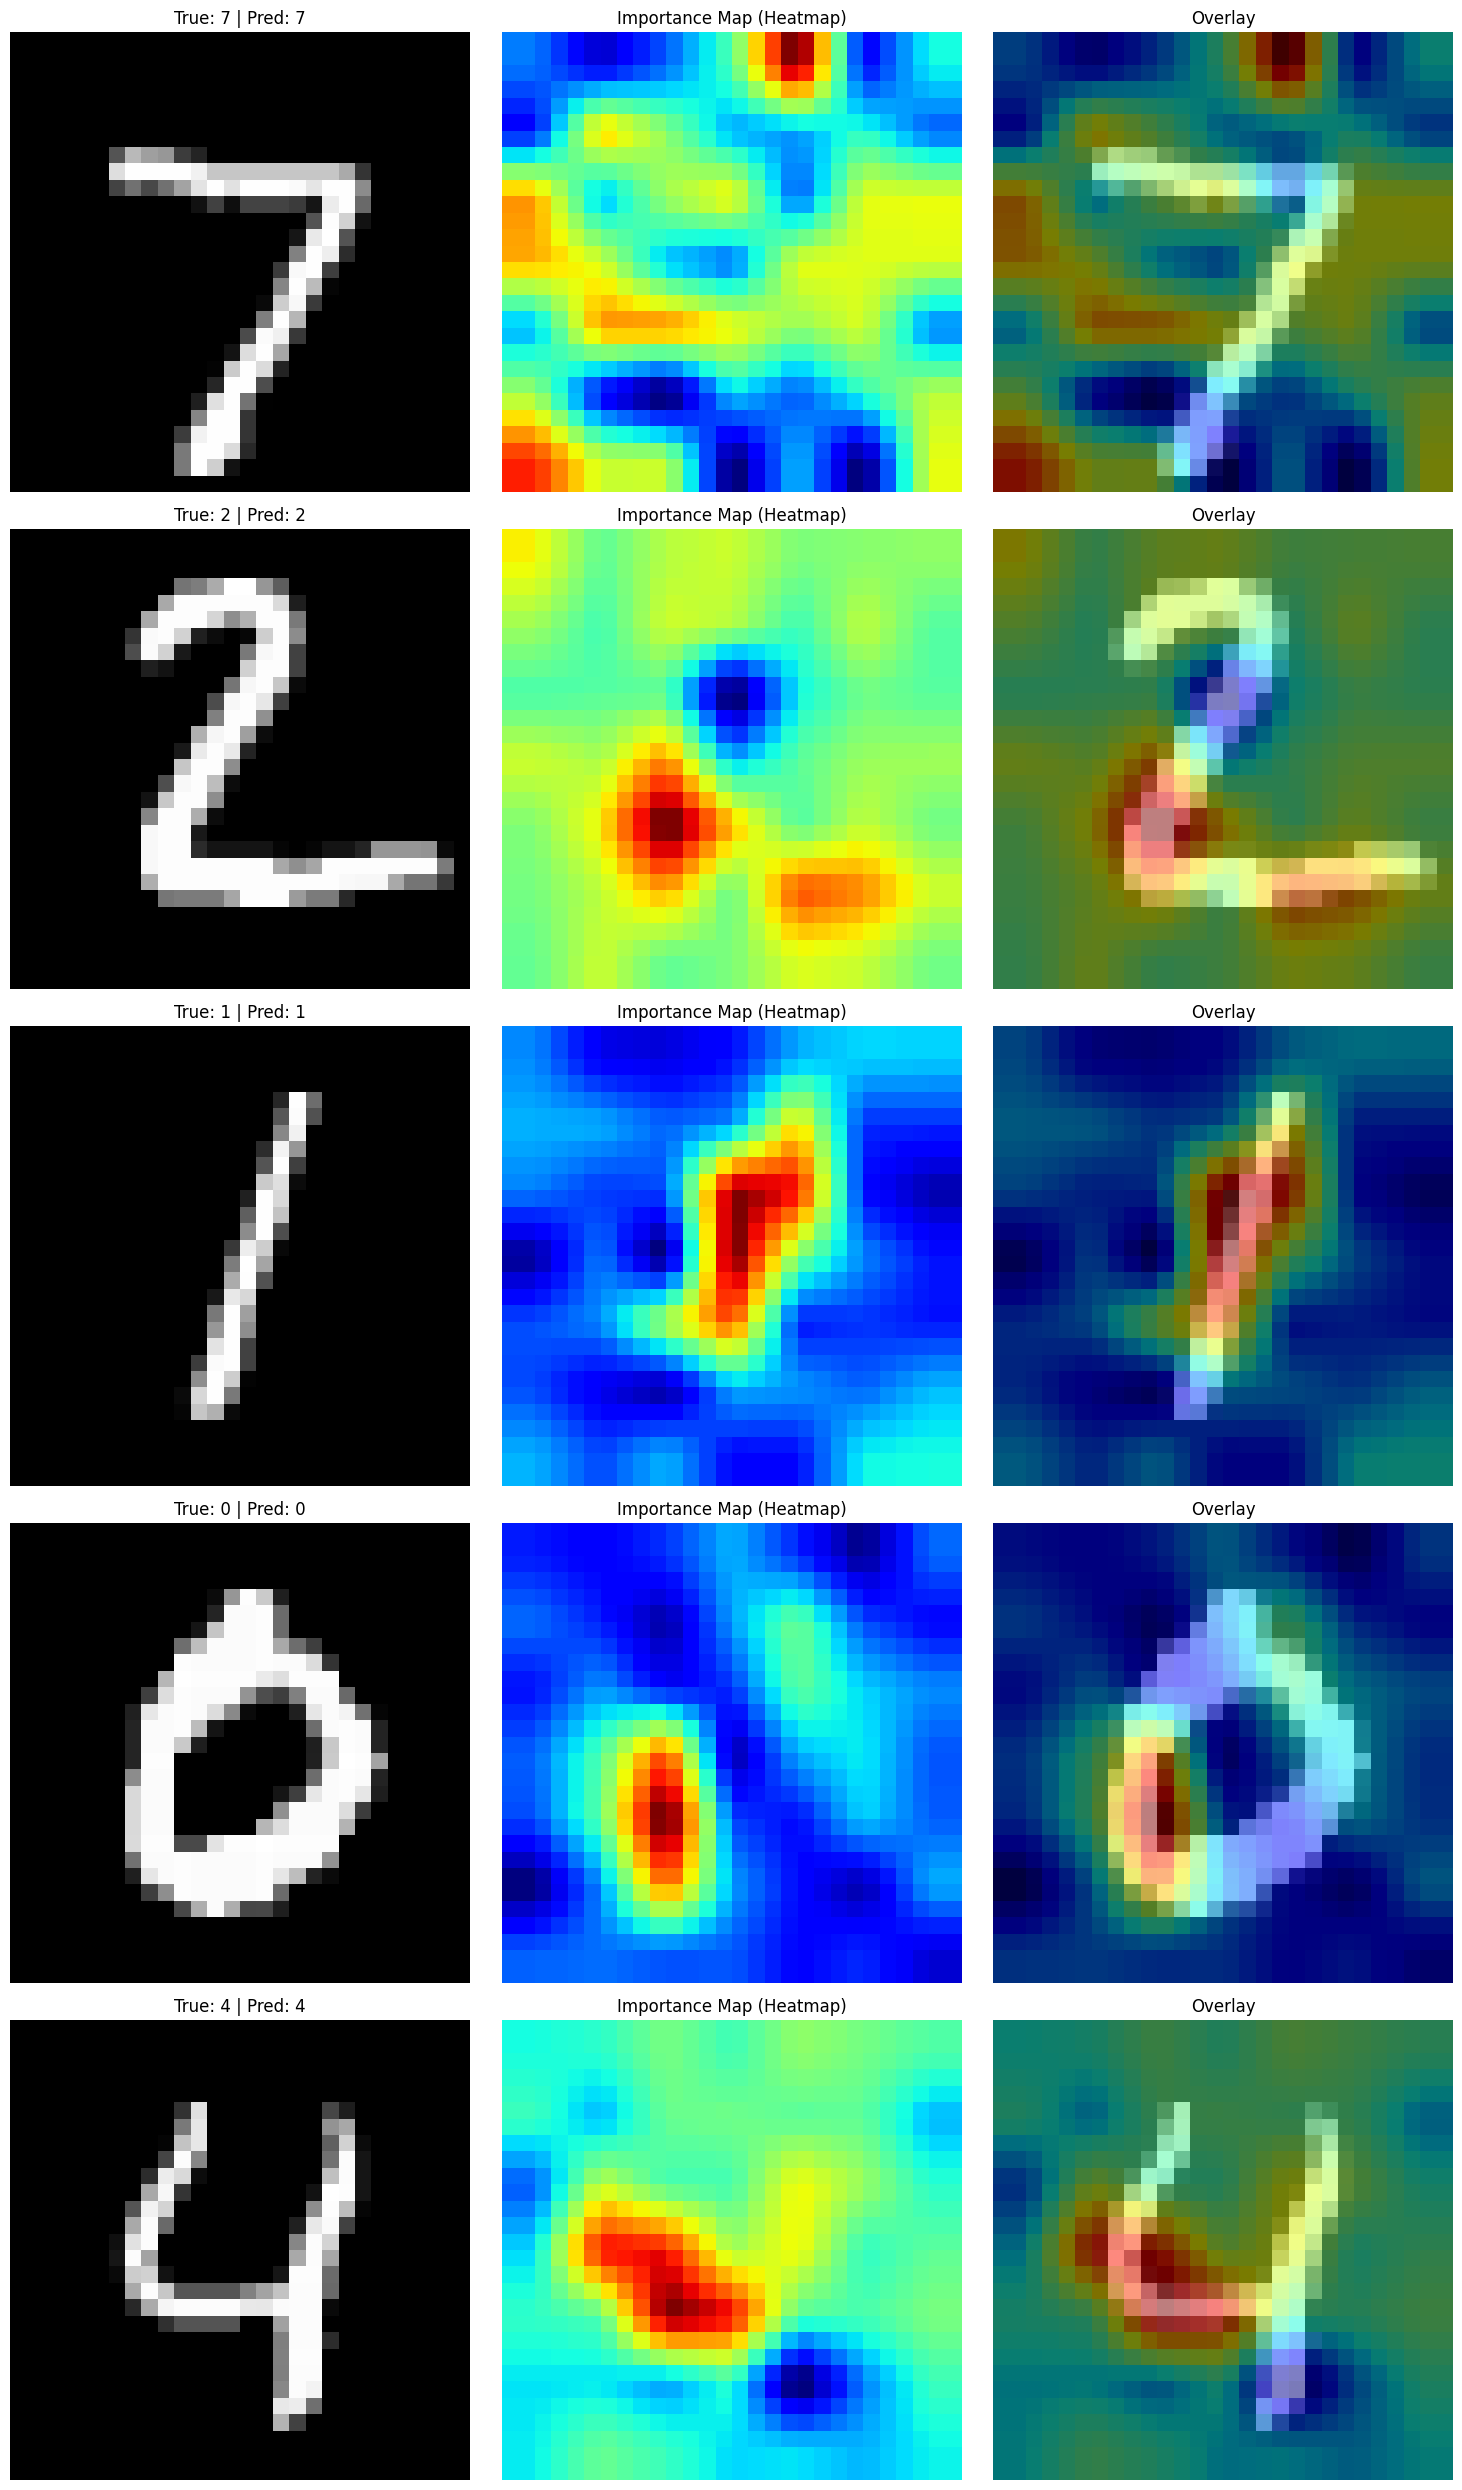

In [6]:
def visualize_rise_on_samples(loader, explainer, num_samples=3, N=3000, s=7, p1=0.5):
    data_iter = iter(loader)

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Get a single image
        img, label = next(data_iter)
        img = img.to(DEVICE)

        #  Run RISE
        heatmap, pred_class = explainer(img, N=N, s=s, p1=p1)

        # Prepare for plotting
        img_np = img.cpu().squeeze().numpy()
        heatmap_np = heatmap.cpu().numpy()

        # Row layout
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {label.item()} | Pred: {pred_class}")
        plt.axis('off')

        # Importance Heatmap (Raw)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(heatmap_np, cmap='jet')
        plt.title("Importance Map (Heatmap)")
        plt.axis('off')

        # Overlay (Image + Heatmap)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(img_np, cmap='gray') # Background
        plt.imshow(heatmap_np, cmap='jet', alpha=0.5) # Overlay with transparency
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
print("Running RISE on test images...")
visualize_rise_on_samples(testloader, rise_explainer, num_samples=5)

Visualizing RISE on 5 false predictions...


RISE Sampling: 100%|██████████| 30/30 [00:00<00:00, 2379.16it/s]


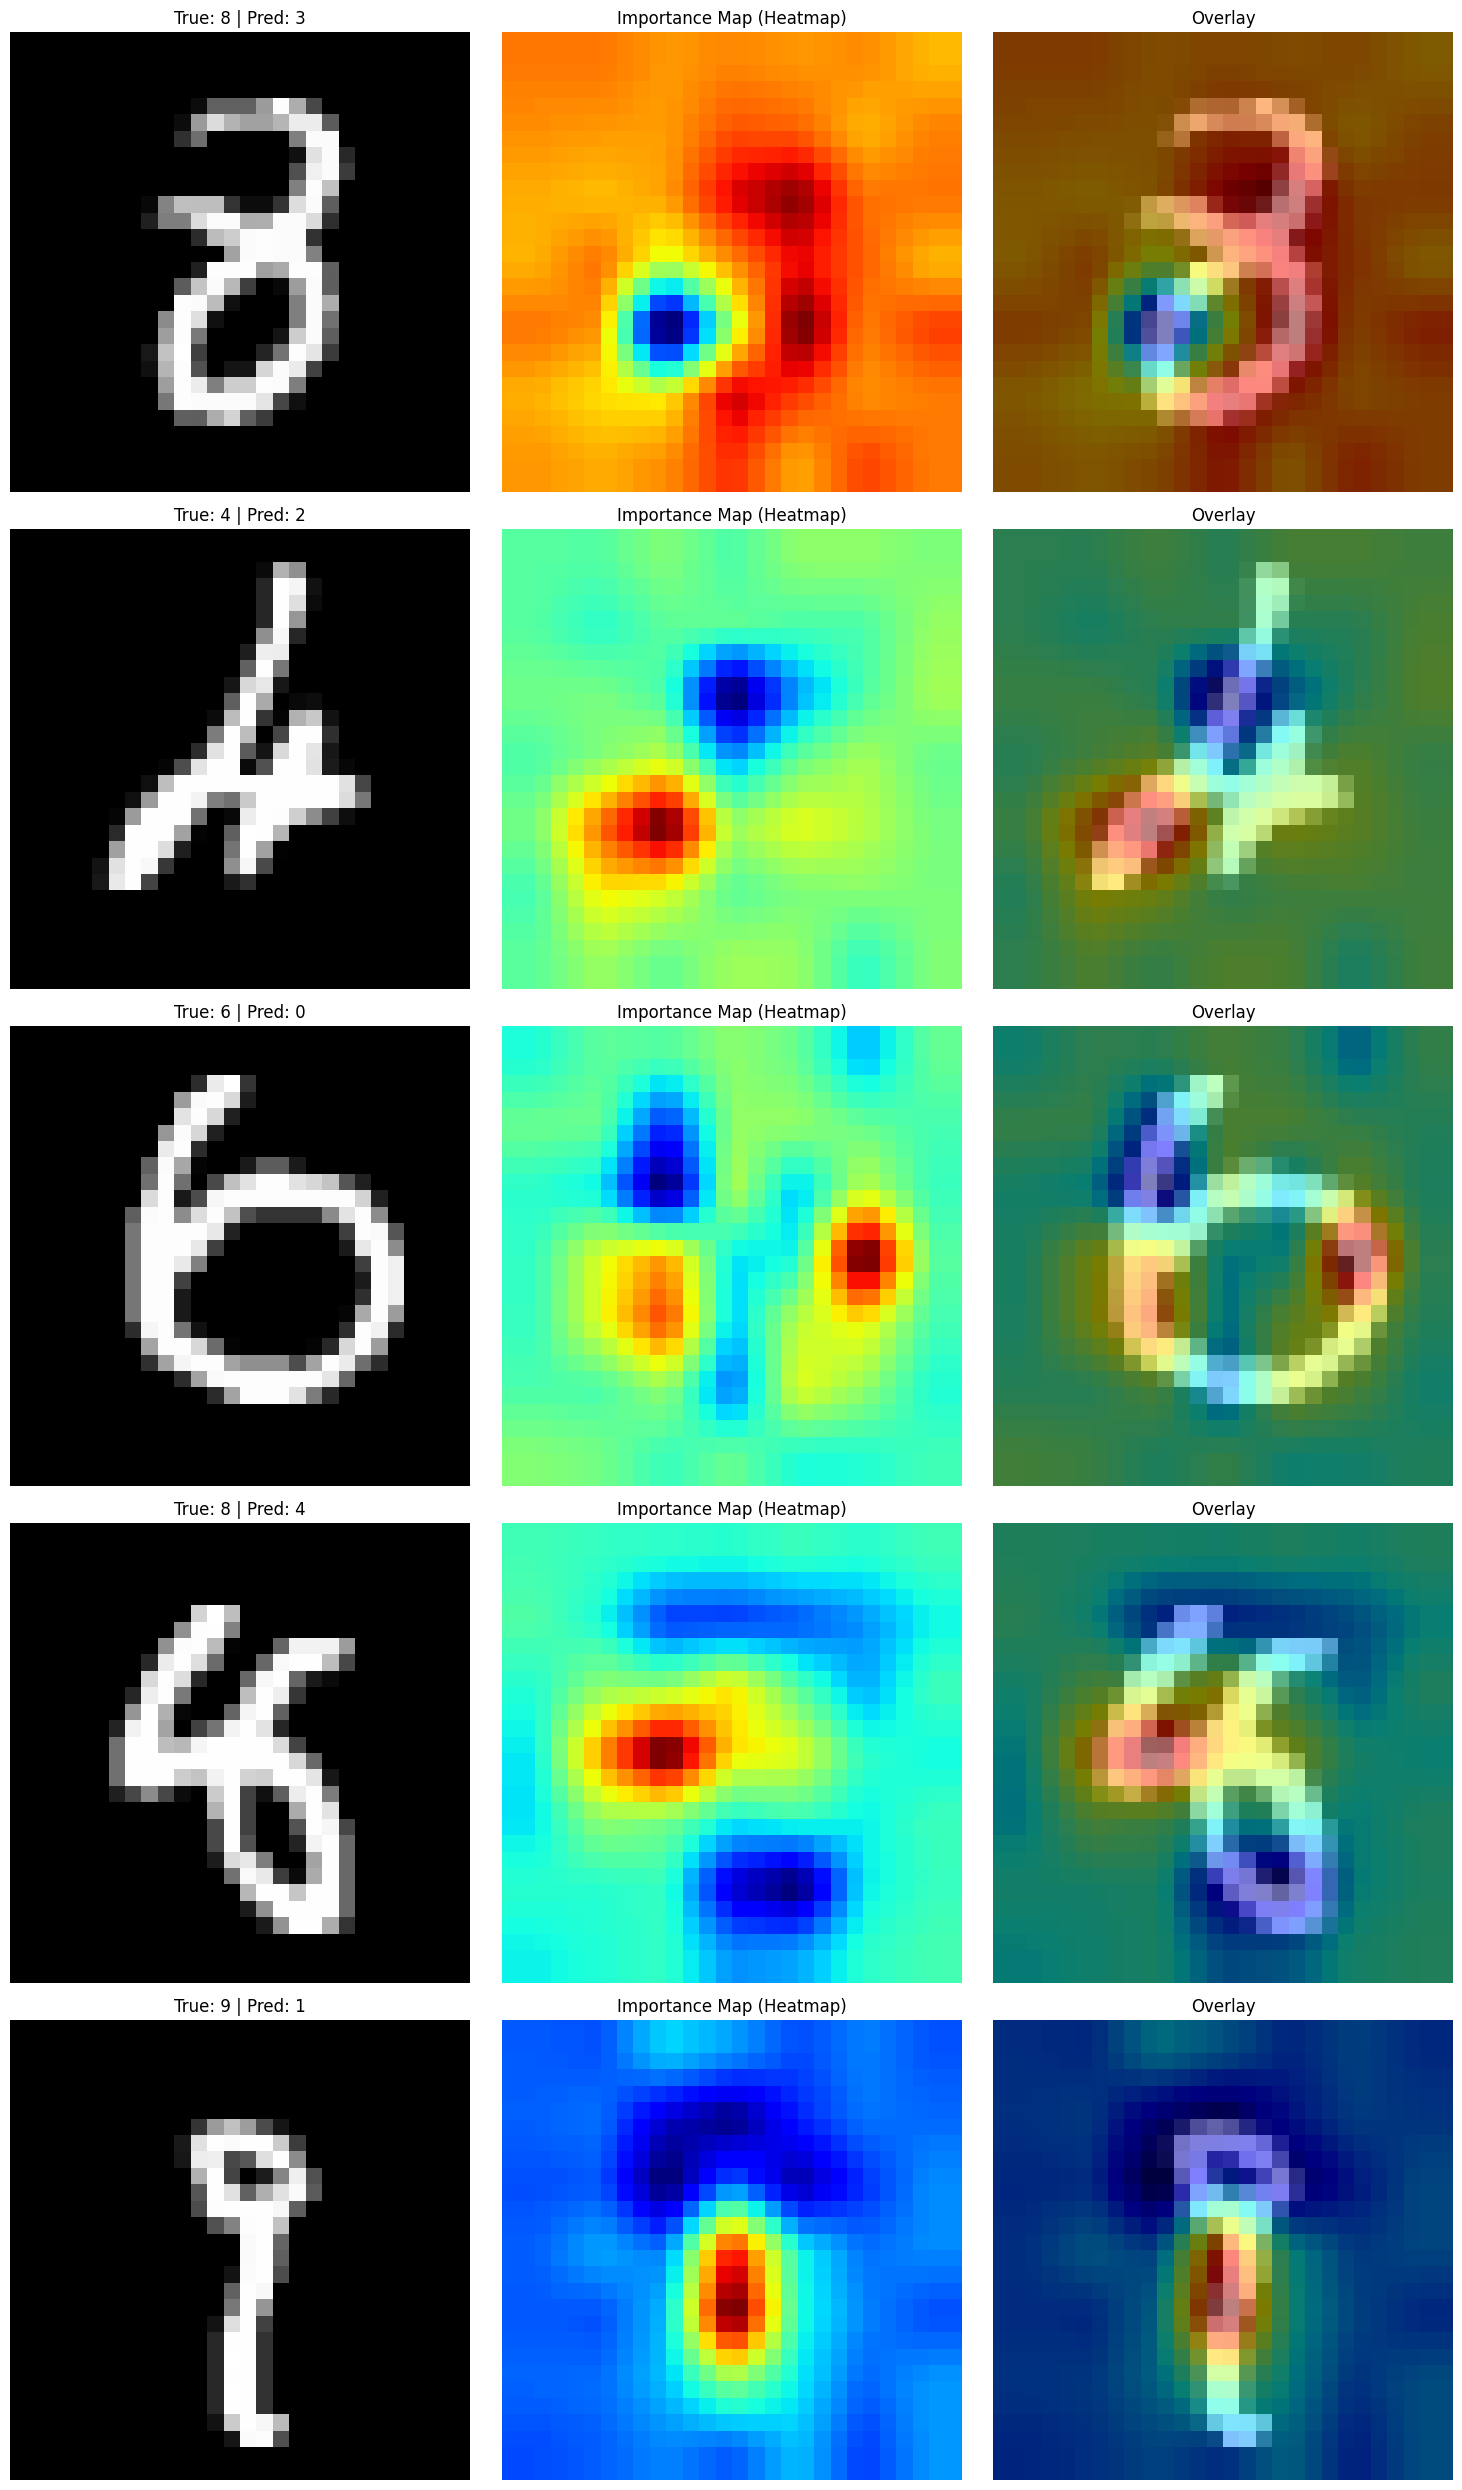

In [7]:
def visualize_rise_on_false_predictions(loader, explainer, num_samples=3, N=3000, s=7, p1=0.5):
    false_predictions = []

    # First, collect false predictions
    with torch.no_grad():
        for data, target in loader:
            img_single, label_single = data.to(DEVICE), target.to(DEVICE)
            output = explainer.model(img_single)
            _, pred_label = torch.max(output, 1)

            if pred_label.item() != label_single.item():
                false_predictions.append((img_single, label_single.item(), pred_label.item()))
            if len(false_predictions) >= num_samples:
                break

    if not false_predictions:
        print("No false predictions found in the sampled batch to visualize.")
        return

    plt.figure(figsize=(15, 5 * len(false_predictions)))

    print(f"Visualizing RISE on {len(false_predictions)} false predictions...")
    for i, (img, true_label, predicted_label) in enumerate(false_predictions):
        # Run RISE on the misclassified image
        heatmap, _ = explainer(img, N=N, s=s, p1=p1)

        # Prepare for plotting
        img_np = img.cpu().squeeze().numpy()
        heatmap_np = heatmap.cpu().numpy()

        # Original Image
        plt.subplot(len(false_predictions), 3, i*3 + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"True: {true_label} | Pred: {predicted_label}")
        plt.axis('off')

        # Importance Heatmap (Raw)
        plt.subplot(len(false_predictions), 3, i*3 + 2)
        plt.imshow(heatmap_np, cmap='jet')
        plt.title("Importance Map (Heatmap)")
        plt.axis('off')

        # Overlay (Image + Heatmap)
        plt.subplot(len(false_predictions), 3, i*3 + 3)
        plt.imshow(img_np, cmap='gray') # Background
        plt.imshow(heatmap_np, cmap='jet', alpha=0.5) # Overlay with transparency
        plt.title("Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization for false predictions
visualize_rise_on_false_predictions(testloader, rise_explainer, num_samples=5)

### **Comparasion with GradCam**

In [8]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward Pass
        self.model.zero_grad()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Backward Pass (to get gradients)
        score = output[:, class_idx]
        score.backward()

        # Get captured data
        # Gradients: (Batch, Channels, H, W)
        # Activations: (Batch, Channels, H, W)
        grads = self.gradients
        fmaps = self.activations

        # Global Average Pooling of Gradients (The "Weights")
        # specific to the channel
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)

        # Weighted Combination of Feature Maps
        # (Weights * Activations)
        cam = (weights * fmaps).sum(dim=1, keepdim=True)

        # Apply ReLU (we only care about positive influence)
        cam = F.relu(cam)

        # Upsample to original image size (28x28) for visualization
        cam = F.interpolate(cam, size=(28, 28), mode='bilinear', align_corners=False)

        # Normalize between 0 and 1
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)

        return cam.squeeze()

# Initialize Grad-CAM focusing on conv2 (the last convolutional layer)
gradcam_explainer = GradCAM(model, target_layer=model.conv2)
print("Grad-CAM initialized on layer: conv2")

Grad-CAM initialized on layer: conv2


Running Comparison...


RISE Sampling: 100%|██████████| 50/50 [00:00<00:00, 2143.74it/s]


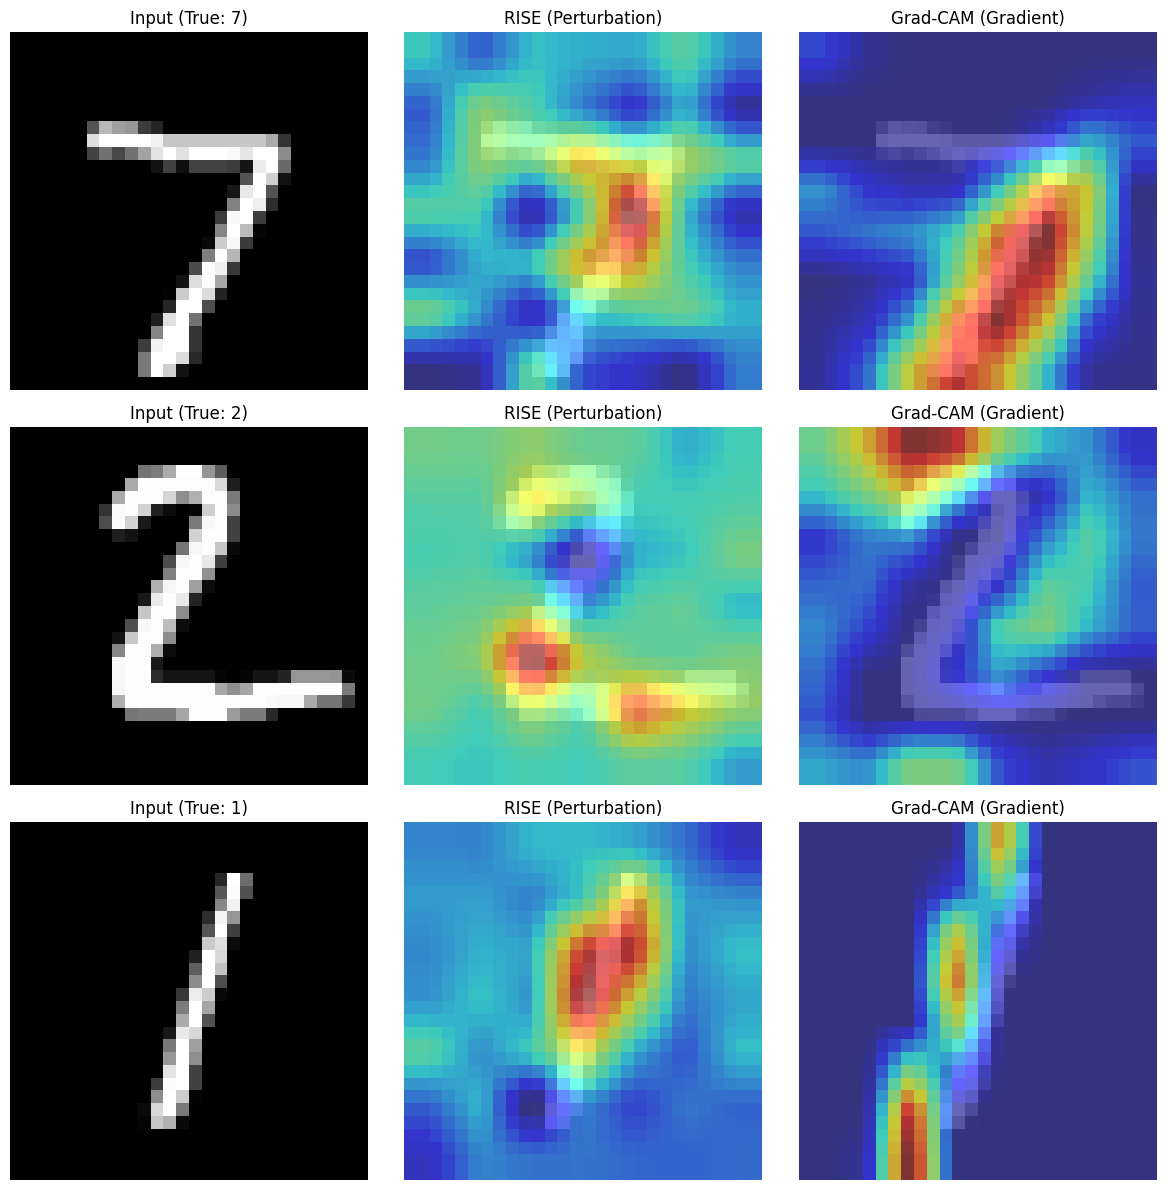

In [9]:
def compare_methods(loader, rise_model, gradcam_model, num_samples=3):
    data_iter = iter(loader)

    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        img, label = next(data_iter)
        img = img.to(DEVICE)

        # Run RISE
        rise_map, pred_class = rise_model(img, N=5000, s=7, p1=0.5)

        # Run Grad-CAM
        gradcam_map = gradcam_model(img, class_idx=pred_class)

        # Convert to numpy for plotting
        img_np = img.cpu().squeeze().numpy()
        rise_np = rise_map.cpu().numpy()
        gc_np = gradcam_map.cpu().detach().numpy()

        # Plotting
        # Original
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Input (True: {label.item()})")
        plt.axis('off')

        # RISE
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(img_np, cmap='gray', alpha=0.5)
        plt.imshow(rise_np, cmap='jet', alpha=0.6)
        plt.title("RISE (Perturbation)")
        plt.axis('off')

        # Grad-CAM
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(img_np, cmap='gray', alpha=0.5)
        plt.imshow(gc_np, cmap='jet', alpha=0.6)
        plt.title("Grad-CAM (Gradient)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Running Comparison...")
compare_methods(testloader, rise_explainer, gradcam_explainer)

### Analyzing RISE hyperparameters

--- Experiment 1: Effect of N (Sample Count) ---


RISE Sampling: 100%|██████████| 30/30 [00:00<00:00, 1844.33it/s]


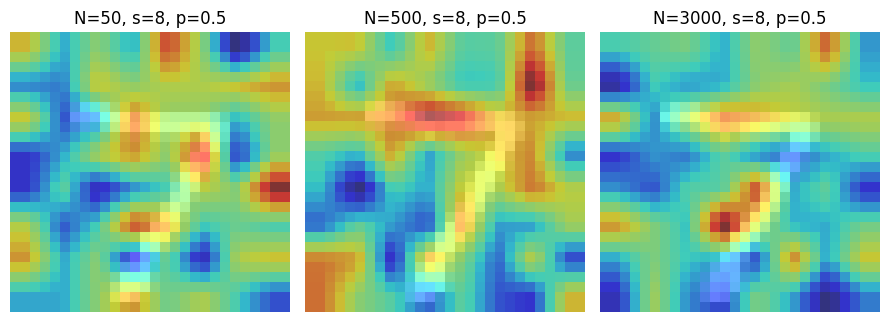

--- Experiment 2: Effect of s (Grid Resolution) ---


RISE Sampling: 100%|██████████| 20/20 [00:00<00:00, 1957.26it/s]


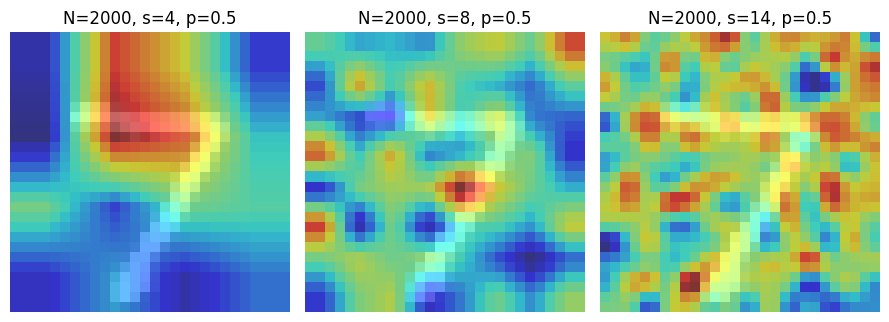

--- Experiment 3: Effect of p1 (Mask Density) ---


RISE Sampling: 100%|██████████| 20/20 [00:00<00:00, 1703.13it/s]


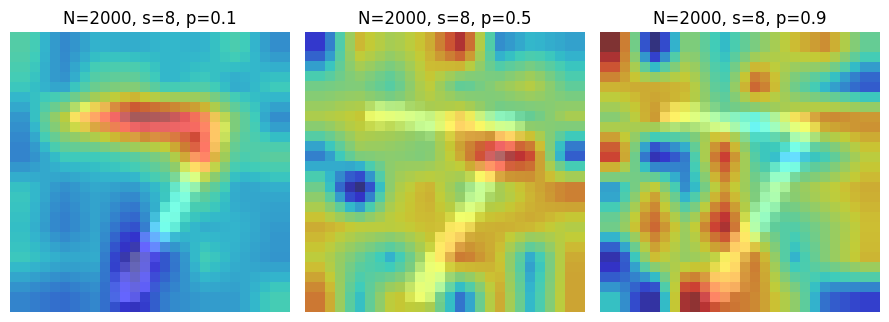

In [9]:
def analyze_hyperparameters(loader, explainer, param_sets):
    """
    param_sets: List of dictionaries, e.g., [{'N': 100, 's': 8, 'p1': 0.5}, ...]
    """
    # Get one fixed image for consistent comparison (e.g., a '2' or '0')
    img, label = next(iter(loader))
    img = img.to(DEVICE)
    img_np = img.cpu().squeeze().numpy()

    # Create a figure
    num_experiments = len(param_sets)
    plt.figure(figsize=(3 * num_experiments, 4))

    for i, params in enumerate(param_sets):
        N = params['N']
        s = params['s']
        p1 = params['p1']

        # Run RISE with specific params
        heatmap, _ = explainer(img, N=N, s=s, p1=p1)
        heatmap_np = heatmap.cpu().numpy()

        # Plot
        plt.subplot(1, num_experiments, i+1)
        plt.imshow(img_np, cmap='gray', alpha=0.5)
        plt.imshow(heatmap_np, cmap='jet', alpha=0.6)
        plt.title(f"N={N}, s={s}, p={p1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Define the experiments
# We will look at 3 groups of comparisons
print("--- Experiment 1: Effect of N (Sample Count) ---")
exp_N = [
    {'N': 50,   's': 8, 'p1': 0.5},  # Very low -> Noisy
    {'N': 500,  's': 8, 'p1': 0.5},  # Medium
    {'N': 3000, 's': 8, 'p1': 0.5},  # High -> Smooth / Converged
]
analyze_hyperparameters(testloader, rise_explainer, exp_N)

print("--- Experiment 2: Effect of s (Grid Resolution) ---")
exp_s = [
    {'N': 2000, 's': 4,  'p1': 0.5}, # Low Res -> Blocky
    {'N': 2000, 's': 8,  'p1': 0.5}, # Balanced
    {'N': 2000, 's': 14, 'p1': 0.5}, # High Res -> Detailed but might be noisy if N is low
]
analyze_hyperparameters(testloader, rise_explainer, exp_s)

print("--- Experiment 3: Effect of p1 (Mask Density) ---")
exp_p = [
    {'N': 2000, 's': 8, 'p1': 0.1},  # Mostly Black -> Hard for model to see anything
    {'N': 2000, 's': 8, 'p1': 0.5},  # Balanced
    {'N': 2000, 's': 8, 'p1': 0.9},  # Mostly Visible -> Scores saturate
]
analyze_hyperparameters(testloader, rise_explainer, exp_p)

# Critical Analysis and Conclusion on the RISE Algorithm

## Critical Discussion: Strengths & Limitations

Based on the implementation and results obtained in this project, here is a detailed evaluation of the **RISE (Randomized Input Sampling for Explanation)** method.

---

## **Properties of the Method**

### **Stability — Stochastic Method**

RISE’s stability depends directly on the number of masks **N**. With a small **N** (e.g., < 1000), two runs on the same image will produce noticeably different heatmaps. Stability improves when **N** is large (e.g., **N = 4000**) because the Monte Carlo approximation converges toward the true importance distribution.

### **Robustness — Relatively High**

By averaging thousands of perturbations, RISE smooths out noise. Compared to pure gradient-based methods (Saliency, DeconvNet), which suffer from "shattered gradients," RISE produces more visually coherent explanations.

### **Sensitivity to Noise — Low**

RISE is less sensitive to imperceptible local variations or adversarial noise. It measures **regional importance** based on masking rather than pixel-level sensitivity.

### **Computational Cost — Very High**

This is the major drawback. Explaining a single image requires **N forward passes**. For **N = 4000**, generating an explanation is **4000× slower** than a simple prediction.

---

## Comparison with Classical Methods (LIME, SHAP, Grad-CAM)

### **Advantages**

* **Model-Agnostic:** Works with any classifier, unlike Grad-CAM which requires access to gradients and CNN structure.
* **High Spatial Resolution:** RISE works directly on the input, producing finer heatmaps than Grad-CAM.
* **Intuitive Visualizations:** Often clearer and less noisy than LIME for images.

### **Disadvantages**

* **Extremely Slow:** Not suitable for real-time applications.
* **Weaker Theoretical Basis:** RISE is heuristic, unlike SHAP’s foundation in Shapley values.

---

##  Limitations and Interpretation Pitfalls

### **Hyperparameter Sensitivity**

Mask grid size *(s, s)* and masking probability **p** strongly influence results. Coarse masks lack precision; fine masks add noise.

### **Out-of-Distribution (OOD) Artifacts**

Randomly masked images may be unrealistic, causing unpredictable model responses.

### **Confirmation Bias**

There is a risk of adjusting **N** or **p** until obtaining a visually pleasing explanation, reducing objectivity.

---

##  Contexts of Use

### **Useful**

* Black-box model audits
* Offline explainability reports
* Model debugging

### **Risky**

* Real-time critical systems
* Embedded/mobile systems due to compute cost

---

##  Conclusion & Key Takeaways

RISE is powerful but computationally expensive.

### **Key Points**

* Works with any model outputting probabilities.
* Great heatmap resolution but slow for large **N**.
* Hyperparameter tuning critical for stable results.


---

##  References

* **Original Paper:** RISE: Randomized Input Sampling for Explanation of Black-box Models (Petsiuk et al., 2018)
